In order to convert from .HEIC to .jpg, these prcesses were followed
<br>
sudo sed -Ei 's/^# deb-src /deb-src /' /etc/apt/sources.list
<br>
sudo apt-get update
<br>
sudo apt-get install build-essential autoconf libtool git-core
<br>
sudo apt-get build-dep imagemagick libmagickcore-dev libde265 libheif
<br>
cd /usr/src/
<br>
sudo git clone https://github.com/strukturag/libde265.git 
<br>
sudo git clone https://github.com/strukturag/libheif.git 
<br>
cd libde265/ 
<br>
sudo ./autogen.sh 
<br>
sudo ./configure 
<br>
sudo make  
<br>
sudo make install 
<br>
cd /usr/src/libheif/ 
<br>
sudo ./autogen.sh 
<br>
sudo ./configure 
<br>
sudo make  
<br>
sudo make install 
<br>
cd /usr/src/ 
<br>
sudo wget https://www.imagemagick.org/download/ImageMagick.tar.gz 
<br>
sudo tar xf ImageMagick.tar.gz 
<br>
cd ImageMagick-7*
<br>
sudo ./configure --with-heic=yes 
<br>
sudo make  
<br>
sudo make install  
<br>
sudo ldconfig
<br>

using WSL before pip installing heic-to-jpg (!pip install heic-to-jpg) then running the command (!heic-to-jpg -s IMG_7935.HEIC --keep)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

%cd gdrive/MyDrive

Mounted at /content/gdrive
/content/gdrive/MyDrive


In [ ]:
from PIL import Image
import cv2 as cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import time

In [ ]:
m = '/content/gdrive/MyDrive/Documents/for_colab'

In [ ]:
def resize_images(in_dir, out_dir):
    pic_files = [f for f in listdir(in_dir) if isfile(join(in_dir, f))]
    
    for i, data in enumerate(pic_files):
        image = Image.open(os.path.join(in_dir, data))
        new_image = image.resize((64, 64))
        new_image.save(os.path.join(out_dir, data))

m = '/content/gdrive/MyDrive/Documents/for_colab'        
in_dirs = [m + '/Shell_output/bad', m + '/Kernel_output/bad', m + '/Shell_output/good', m + '/Kernel_output/good']
out_dirs = [m + '/Shell_output/bad_resize', m + '/Kernel_output/bad_resize', m + '/Shell_output/good_resize', m + '/Kernel_output/good_resize']

def resize_images_with_dirs(in_dirs, out_dirs):
    for i, data in enumerate(in_dirs):
        resize_images(data, out_dirs[i])
        
resize_images_with_dirs(in_dirs, out_dirs)

In [ ]:
#Augment Images
def aug_img(in_dir, out_dir):
    pic_files = [f for f in listdir(in_dir) if isfile(join(in_dir, f))]
    
    for i, data in enumerate(pic_files):
        name, ext = os.path.splitext(data)
        image = Image.open(os.path.join(in_dir, data))
        image.save(os.path.join(out_dir, name + '_0' + ext))
        
        image_rot_90 = image.rotate(90)
        image_rot_90.save(os.path.join(out_dir, name + '_90' + ext))

        image_rot_180 = image.rotate(180)
        image_rot_180.save(os.path.join(out_dir, name + '_180' + ext))

        image_rot_270 = image.rotate(270)
        image_rot_270.save(os.path.join(out_dir, name + '_270' + ext))
        
        image_flip = image.transpose(Image.FLIP_LEFT_RIGHT)
        image_flip.save(os.path.join(out_dir, name + '_flip' + ext))

in_dirs = [m + '/Shell_output/bad_resize', m + '/Kernel_output/bad_resize', m + '/Shell_output/good_resize', m + '/Kernel_output/good_resize']
out_dirs = [m + '/Shell_output/bad_aug', m + '/Kernel_output/bad_aug', m + '/Shell_output/good_aug', m + '/Kernel_output/good_aug']

def aug_img_with_dirs(in_dirs, out_dirs):
    for i, data in enumerate(in_dirs):
        aug_img(data, out_dirs[i])

aug_img_with_dirs(in_dirs, out_dirs)

In [ ]:
!ls '/content/gdrive/MyDrive/Documents/for_colab/Shell_output/bad_aug' -1U | wc -l
!ls '/content/gdrive/MyDrive/Documents/for_colab/Kernel_output/bad_aug' -1U | wc -l
!ls '/content/gdrive/MyDrive/Documents/for_colab/Shell_output/good_aug' -1U | wc -l
!ls '/content/gdrive/MyDrive/Documents/for_colab/Kernel_output/good_aug' -1U | wc -l

50
85
230
420


In [ ]:
def convert_pic_dir_to_numpy(in_dir, lab_val):
    pic_files = [f for f in listdir(in_dir) if isfile(join(in_dir, f))]
    
    res = []
    label = []
    
    for i, data in enumerate(pic_files):
        img = Image.open(os.path.join(in_dir, data))
        imgArray = np.array(img)
        res.append(imgArray)
        label.append(np.array(lab_val))
        
    return [np.array(res), np.array(label)]

out_dirs = [m + '/Shell_output/bad_aug', m + '/Shell_output/good_aug', m + '/Kernel_output/bad_aug', m + '/Kernel_output/good_aug']
labs = [0, 1, 0, 1]

def pic_to_np_with_dirs(out_dirs, labs):
    all_data = []
    for i, data in enumerate(out_dirs):
        all_data.append(convert_pic_dir_to_numpy(data, labs[i]))
    return all_data

all_data = pic_to_np_with_dirs(out_dirs, labs)

In [ ]:
shell_bad_data = all_data[0][0]
shell_bad_label = all_data[0][1]

shell_good_data = all_data[1][0]
shell_good_label = all_data[1][1]

kernel_bad_data = all_data[2][0]
kernel_bad_label = all_data[2][1]

kernel_good_data = all_data[3][0]
kernel_good_label = all_data[3][1]

In [ ]:
shell_good_data.shape

(230, 64, 64, 3)

In [ ]:
_1_shape = shell_bad_data.shape
shell_bad_data_1 = shell_bad_data.reshape(_1_shape[0], _1_shape[1] * _1_shape[2] * _1_shape[3])

_2_shape = shell_good_data.shape
shell_good_data_1 = shell_good_data.reshape(_2_shape[0], _2_shape[1] * _2_shape[2] * _2_shape[3])

_3_shape = kernel_bad_data.shape
kernel_bad_data_1 = kernel_bad_data.reshape(_3_shape[0], _3_shape[1] * _3_shape[2] * _3_shape[3])

_4_shape = kernel_good_data.shape
kernel_good_data_1 = kernel_good_data.reshape(_4_shape[0], _4_shape[1] * _4_shape[2] * _4_shape[3])

In [ ]:
all_shell_data = np.vstack((shell_bad_data_1, shell_good_data_1)) / 255
all_shell_label = np.hstack((shell_bad_label, shell_good_label))
print(all_shell_data.shape)

all_kernel_data = np.vstack((kernel_bad_data_1, kernel_good_data_1)) / 255
all_kernel_label = np.hstack((kernel_bad_label, kernel_good_label))
print(all_kernel_data.shape)

(280, 12288)
(505, 12288)


In [ ]:
sh_X_train, sh_X_test, sh_y_train, sh_y_test = train_test_split(all_shell_data, all_shell_label, test_size=0.33, 
                                                                random_state=42, shuffle=True)

ke_X_train, ke_X_test, ke_y_train, ke_y_test = train_test_split(all_kernel_data, all_kernel_label, test_size=0.33, 
                                                                random_state=42, shuffle=True)

##### KNN P.S.-> It isn't shitty

In [ ]:
def knn_model_default_error(x_data, y_data, n):
    accuracy_list = []
    acc_list_explained = []
    # Calculating error for K values between 1 and 40
    iters = []
    for i in range(1, n+1):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn_scores = cross_val_score(estimator=knn, X=x_data, 
                                     y=y_data, cv=10)
        iters.append(i)
        knn_mean_score = 1-knn_scores.mean()
        accuracy_list.append(knn_mean_score)
        acc_list_explained.append((i,knn_mean_score))
    best_k_fold = acc_list_explained[accuracy_list.index(min(accuracy_list))]
    return accuracy_list, iters, acc_list_explained, best_k_fold

In [ ]:
# acc_list_train_1, iters_list_train_1, acc_list_exploded_train_1, best_k_fold_value_train_1 = knn_model_default_error(
#     sh_X_train, sh_y_train, 20)
# acc_list_test_1, iters_list_test_1, acc_list_exploded_test_1, best_k_fold_value_test_1 = knn_model_default_error(
#     sh_X_test, sh_y_test, 20)
acc_list_test_1, iters_list_test_1, acc_list_exploded_test_1, best_k_fold_value_test_1 = knn_model_default_error(
    all_shell_data, all_shell_label, 20)

In [ ]:
acc_list_exploded_test_1

[(1, 0.20714285714285718),
 (2, 0.2142857142857142),
 (3, 0.15000000000000002),
 (4, 0.13928571428571423),
 (5, 0.13214285714285712),
 (6, 0.1357142857142858),
 (7, 0.125),
 (8, 0.125),
 (9, 0.13928571428571423),
 (10, 0.13214285714285712),
 (11, 0.12857142857142845),
 (12, 0.125),
 (13, 0.13928571428571423),
 (14, 0.13928571428571423),
 (15, 0.15000000000000002),
 (16, 0.13928571428571446),
 (17, 0.15714285714285714),
 (18, 0.15000000000000002),
 (19, 0.1607142857142858),
 (20, 0.1607142857142858)]

Text(0, 0.5, 'Error')

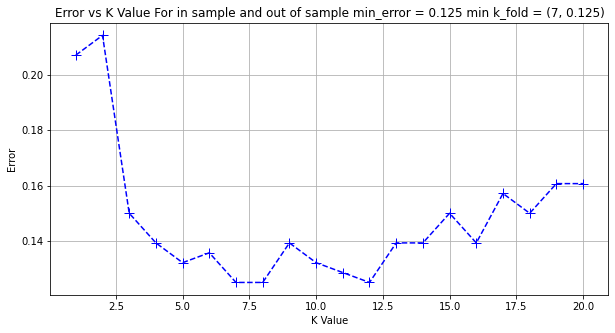

In [ ]:
plt.figure(figsize=(10, 5))
# plt.plot(iters_list_train_1, acc_list_train_1, color='red', linestyle='dashed', marker='o',
#          markerfacecolor='green', markersize=10)
plt.plot(iters_list_test_1, acc_list_test_1, color='blue', linestyle='dashed', marker='+',
         markerfacecolor='green', markersize=10)
plt.title('Error vs K Value For in sample and out of sample min_error = ' 
          + str(min(acc_list_test_1)) + ' min k_fold = ' + str(best_k_fold_value_test_1))
plt.grid()
plt.xlabel('K Value')
plt.ylabel('Error')

In [ ]:
min(acc_list_test_1)

0.13888888888888895

#### MLP

In [ ]:
class MyDataset(Dataset):
    
    # load the dataset
    def __init__(self, x, y):
        
        # store the inputs and outputs
        self.X = x
        self.y = y
        
    # number of rows in the dataset
    def __len__(self):
        return len(self.y)

    def yyy(self, index):
      return torch.from_numpy(np.asarray(self.y[index])).long()
 
    # get a row at an index
    def __getitem__(self, index):
            
        ### Get data at index pair with context (1 line)
        xx = torch.Tensor(self.X[index]).float()
            
        ### Get label at index pair (1 line)
        yy = torch.from_numpy(np.asarray(self.y[index])).long()
            
        ### Return data at index pair with context and label at index pair (1 line)
        return xx, yy

In [ ]:
cuda = torch.cuda.is_available()
num_workers = 8 if cuda else 0
print("Cuda = "+str(cuda)+" with num_workers = "+str(num_workers))

Cuda = True with num_workers = 8


In [ ]:
# training dataloader
train_data = MyDataset(sh_X_train, sh_y_train)
train_args = dict(shuffle = True, batch_size = 8, 
                  num_workers = num_workers, pin_memory = True, drop_last=True) if cuda else dict(shuffle = True, batch_size = 256)
train_loader = DataLoader(train_data, **train_args)

# Validation dataloader
val_data = MyDataset(sh_X_test, sh_y_test)
val_args = dict(shuffle = False, batch_size = 8, 
                num_workers = num_workers, pin_memory = True) if cuda else dict(shuffle = False, batch_size = 1)
val_loader = DataLoader(val_data, **val_args)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
x,y = train_data.__getitem__(0)

In [ ]:
x

tensor([0.7373, 0.6510, 0.8314,  ..., 0.6706, 0.6039, 0.7804])

In [ ]:
y

tensor(1)

In [ ]:
## Model Architecture definition

class MLP(nn.Module):

    # define model elements
    def __init__(self, size_list):
        super(MLP, self).__init__()
        layers = []
        # Sequential model definition: Input -> Linear -> ReLU -> Linear -> Output

        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i], size_list[i+1]))
            
            if i < 2:
                layers.append(nn.BatchNorm1d(size_list[i+1]))

            if i <= 2:
                layers.append(nn.Dropout(0.3))

            layers.append(nn.ReLU())
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        # Model forward pass
        return self.net(x)

In [ ]:
#Try 1: [64 * 64 * 3, 8192,1024,64,2] //lr = 0.001
model = MLP([64 * 64 * 3, 8192,1024,64,2])

# Define Criterion/ Loss function
criterion = nn.CrossEntropyLoss()

# Define Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

device = torch.device("cuda" if cuda else "cpu")
model.to(device)

print(model)

MLP(
  (net): Sequential(
    (0): Linear(in_features=12288, out_features=8192, bias=True)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=8192, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): ReLU()
    (8): Linear(in_features=1024, out_features=64, bias=True)
    (9): Dropout(p=0.3, inplace=False)
    (10): ReLU()
    (11): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [ ]:
# Train the model

def train_model(train_loader, model, criterion, optimizer):
    print("Training...")
    
    # Set model in 'Training mode'
    model.train()

    training_loss = 0.0
    total_predictions = 0.0
    correct_prediction = 0.0

    start_time = time.time()
    
    # enumerate mini batches
    for i, (data, target) in enumerate(train_loader):
        
        # clear the gradients
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device)
        
        # compute the model output
        outputs = model(data)
        
        # calculate loss
        loss = criterion(outputs, target.long())
        
        # Backward pass
        loss.backward()
        
        # Update model weights
        optimizer.step()


        _, predicted = torch.max(outputs.data, 1)

        total_predictions += target.size(0)

        correct_prediction += (predicted == target).float().sum().item()
        
        training_loss += loss.item()


    end_time = time.time()
    training_loss /= len(train_loader)

    print("Training Loss = ", training_loss, " Time = ", end_time - start_time, "s")
    acc = (correct_prediction/total_predictions) * 100
    print("Training accuracy = ", acc, "%")

    return training_loss, acc

In [ ]:
def evaluate_model(val_loader, model, criterion):

    print("Validating...")

    with torch.no_grad():

        running_loss = 0.0
        total_predictions = 0.0
        correct_prediction = 0.0
        
        # Set model in validation mode
        model.eval()
        
        for i, (inputs, target) in enumerate(val_loader):

            inputs = inputs.to(device)
            target = target.reshape(-1)
            target = target.to(device)
            
            # evaluate the model on the validation set
            out = model(inputs)
                    
            # Calculate validation loss
            loss = criterion(out, target.long()).detach()

            _, predicted = torch.max(out.data, 1)

            total_predictions += target.size(0)

            correct_prediction += (predicted == target).float().sum().item()
            
            running_loss += loss.item()
        

        running_loss /= len(val_loader)

        print("Training Loss = ", running_loss)
        acc = (correct_prediction/total_predictions) * 100
        print("Training accuracy = ", acc, "%")

        return running_loss, acc

In [ ]:
directory_to_extract_to = '/content/gdrive/MyDrive/Documents/for_colab/Models'

In [ ]:
epochs = 20

Train_loss = []
Test_loss = []
Test_acc = []
Train_acc = []

trial = 4

val_losses = 10000

for epoch in range(epochs):
    
    print("Epoch Number = ", epoch)
    # Train
    training_loss, taining_acc = train_model(train_loader, model, criterion, optimizer)
    val_loss, val_acc = evaluate_model(train_loader, model, criterion)

    Train_loss.append(training_loss)
    Test_loss.append(val_loss)
    Test_acc.append(val_acc)
    Train_acc.append(taining_acc)

    if val_loss < val_losses:
      val_losses = val_loss
      PATH = directory_to_extract_to + '/'+'trial'+str(trial)+'epoch'+str(epoch)+'.pth'
      torch.save(model.state_dict(), PATH)
    
    # Print log of accuracy and loss
    print("Epoch: "+str(epoch)+", Training loss: "+str(training_loss)+", Validation loss:"+str(val_loss)+
          ", Validation accuracy:"+str(val_acc)+"%")
    print("="*20)

Epoch Number =  0
Training...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Loss =  0.11091427881594586  Time =  1.5892176628112793 s
Training accuracy =  94.56521739130434 %
Validating...
Training Loss =  0.020364445279878768
Training accuracy =  100.0 %
Epoch: 0, Training loss: 0.11091427881594586, Validation loss:0.020364445279878768, Validation accuracy:100.0%
Epoch Number =  1
Training...
Training Loss =  0.06745622856744929  Time =  1.57069730758667 s
Training accuracy =  97.82608695652173 %
Validating...
Training Loss =  0.4935493867682374
Training accuracy =  73.36956521739131 %
Epoch: 1, Training loss: 0.06745622856744929, Validation loss:0.4935493867682374, Validation accuracy:73.36956521739131%
Epoch Number =  2
Training...
Training Loss =  0.10897436028893065  Time =  1.5510690212249756 s
Training accuracy =  95.1086956521739 %
Validating...
Training Loss =  0.008146220108281577
Training accuracy =  100.0 %
Epoch: 2, Training loss: 0.10897436028893065, Validation loss:0.008146220108281577, Validation accuracy:100.0%
Epoch Number =  3
Train

[]

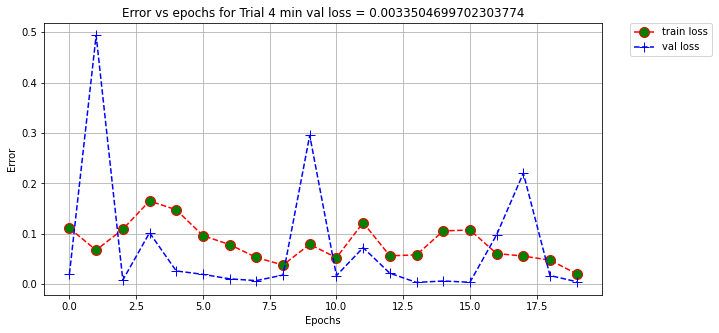

In [ ]:
#Trial 3 chart
plt.figure(figsize=(10, 5))
plt.plot(np.arange(epochs), Train_loss, color='red', linestyle='dashed', marker='o',
         markerfacecolor='green', markersize=10, label = 'train loss')
plt.plot(np.arange(epochs), Test_loss, color='blue', linestyle='dashed', marker='+',
         markerfacecolor='green', markersize=10, label = 'val loss')
plt.title('Error vs epochs for Trial ' + str(trial) + ' min val loss = ' + str(min(Test_loss)))
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.plot()

In [ ]:
!pip install daft